In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .config("spark.driver.memory", "8g")\
    .getOrCreate()

spark

22/02/23 22:30:38 WARN Utils: Your hostname, HOMELAB resolves to a loopback address: 127.0.1.1; using 172.31.115.222 instead (on interface eth0)
22/02/23 22:30:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/23 22:30:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/02/23 22:30:41 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/02/23 22:30:41 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/02/23 22:30:41 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [14]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F
import pyspark.sql.types as T

from cycler import cycler
from pyspark.sql.functions import col, lit

from common import *

plt.rc('axes', labelsize=15, titlesize=15) 
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
PREFIX = "main/tpcc"
IGNORE_CACHE = False

def get_index(prefix):
    client_sdf = spark.read.csv(f"{prefix}/*/client/0/metadata.csv", header=True)\
        .withColumn(
            "prefix",
            ancestor_udf(F.input_file_name(), lit(3))
        )

    server_sdf = spark.read.csv(f"{prefix}/*/server/0-0/metadata.csv", header=True)\
        .withColumn(
            "prefix",
            ancestor_udf(F.input_file_name(), lit(3))
        )

    index_sdf = server_sdf.join(client_sdf, on='prefix')\
        .withColumn("duration", col("duration").cast(T.IntegerType()))\
        .withColumn("txns", col("txns").cast(T.IntegerType()))\
        .withColumn("clients", col("clients").cast(T.IntegerType()))\
        .withColumn("rate", col("rate").cast(T.IntegerType()))\
        .withColumn("sample", col("sample").cast(T.IntegerType()))

    return index_sdf


index_df = from_cache_or_compute(
    f'{PREFIX}/index.parquet',
    lambda: get_index(PREFIX).toPandas(),
    ignore_cache=IGNORE_CACHE,
)

index_df

,prefix,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:sh_only,wl:mix,wl:mh_zipf,wl:homes,wl:sp_partition
0,file:///home/ctring/data/detock/main/tpcc/base...,1.0.1012,baseline.conf,30,0,100,0,10,tpcc,0,45:43:4:4:4,1,2,-1
1,file:///home/ctring/data/detock/main/tpcc/base...,1.0.1012,baseline.conf,30,0,125,0,10,tpcc,0,45:43:4:4:4,1,2,-1
2,file:///home/ctring/data/detock/main/tpcc/base...,1.0.1012,baseline.conf,30,0,150,0,10,tpcc,0,45:43:4:4:4,1,2,-1
3,file:///home/ctring/data/detock/main/tpcc/base...,1.0.1012,baseline.conf,30,0,175,0,10,tpcc,0,45:43:4:4:4,1,2,-1
4,file:///home/ctring/data/detock/main/tpcc/base...,1.0.1012,baseline.conf,30,0,200,0,10,tpcc,0,45:43:4:4:4,1,2,-1
5,file:///home/ctring/data/detock/main/tpcc/base...,1.0.1012,baseline.conf,30,0,225,0,10,tpcc,0,45:43:4:4:4,1,2,-1
6,file:///home/ctring/data/detock/main/tpcc/ddr_...,1.0.1017,ddr_ts.conf,30,0,100,0,10,tpcc,0,45:43:4:4:4,1,2,-1
7,file:///home/ctring/data/detock/main/tpcc/ddr_...,1.0.1017,ddr_ts.conf,30,0,125,0,10,tpcc,0,45:43:4:4:4,1,2,-1
8,file:///home/ctring/data/detock/main/tpcc/ddr_...,1.0.1017,ddr_ts.conf,30,0,150,0,10,tpcc,0,45:43:4:4:4,1,2,-1
9,file:///home/ctring/data/detock/main/tpcc/ddr_...,1.0.1017,ddr_ts.conf,30,0,175,0,10,tpcc,0,45:43:4:4:4,1,2,-1


# Throughput

In [6]:
IGNORE_CACHE = False

def compute_throughput(prefix):
    res = throughput(
        spark,
        prefix,
        start_offset_sec=5,
        duration_sec=20
    ).first().throughput
    print(prefix, res)
    return res


def compute_all_throughputs(index_sdf):
    # Extract all prefixes in the index
    throughput_df = index_sdf.select("prefix").toPandas()
    # Compute the throughput of each prefix
    throughput_df["throughput"] = throughput_df.apply(lambda r: compute_throughput(r["prefix"]), axis=1)
    # Associate metadata from the index to the throughputs
    return throughput_df.merge(index_sdf.toPandas(), on="prefix")


throughput_df = from_cache_or_compute(
    f'{PREFIX}/throughput.parquet',
    lambda: compute_all_throughputs(get_index(PREFIX)),
    ignore_cache=IGNORE_CACHE,
)

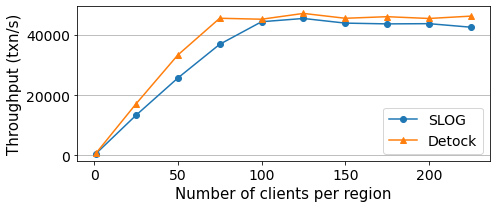

In [7]:
pivot_values = "throughput"
pivot_columns = "config_name"
pivot_index = "clients"
pivoted = throughput_df.pivot(index=pivot_index, columns=pivot_columns, values=pivot_values).sort_index()
pivoted["clients"] = pivoted.index
pivoted.rename(columns={"baseline.conf": "SLOG", "ddr_ts.conf": "Detock"}, inplace=True)
pivoted.columns.name = ''

ax = pivoted.plot(x="clients", xlabel="Number of clients per region", ylabel='Throughput (txn/s)', rot=0, legend=False, figsize=(7,3))

markers = ["o", "^"]
for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])

ax.legend(ax.get_lines(), pivoted.columns)

plt.grid(axis='y')
plt.tight_layout()
plt.savefig('output/tpcc-throughput.pdf')

# Latency

In [24]:
index_sdf = get_index(PREFIX)

latency_sdf = latency(
    spark, 
    map(
        lambda r : r.prefix,
        index_sdf.select("prefix").collect()
    ))\
        .withColumn(
            "coordinator_region",
            (col("coordinator") / 3).cast(T.IntegerType())
        )\
        .join(index_sdf, on="prefix")\
        .orderBy("clients").cache()

22/02/23 22:48:42 WARN CacheManager: Asked to cache already cached data.


# By regions

In [28]:
def plot_latency_per_region(sdf_dict):
    rows = 2
    cols = 4
    fig, ax = plt.subplots(rows, cols, figsize=(14, 6), sharex=True)
    regions = [
        "us-east-2",
        "us-east-1",
        "eu-west-1",
        "eu-west-2",
        "ap-northeast-1",
        "ap-northeast-2",
        "ap-southeast-1",
        "ap-southeast-2"
    ]
    for i in range(8):
        r, c = i // cols, i % cols
        ax[r, c].set_prop_cycle(cycler(linestyle=['-', '--']) + cycler(color='rk'))
        for label, sdf in sdf_dict.items():
            plot_cdf(
                collect_col(sdf.where(col("coordinator_region") == i), "latency"),
                ax=ax[r, c],
                label=label if i == 0 else '_nolegend_',
            )

        ax[r, c].set_title(f"{regions[i]}")
        if r == rows - 1:
            ax[r, c].set_xlabel("latency (ms)")

    return fig, ax

22/02/23 22:52:18 WARN CacheManager: Asked to cache already cached data.
22/02/23 22:52:18 WARN CacheManager: Asked to cache already cached data.


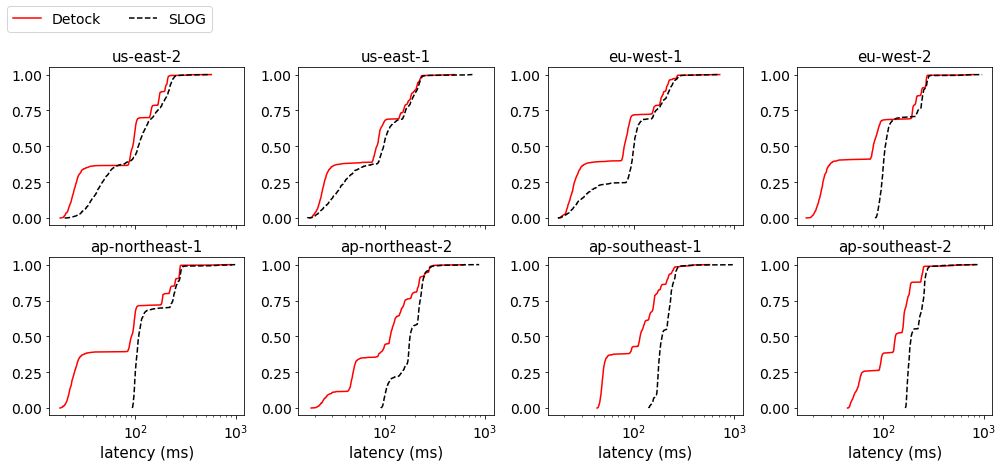

In [29]:
CLIENTS = 100

baseline_sdf = latency_sdf.where((col("config_name") == "baseline.conf") & (col("clients") == CLIENTS)).cache()
ddr_ts_sdf = latency_sdf.where((col("config_name") == "ddr_ts.conf") & (col("clients") == CLIENTS)).cache()


MH_FILTER = F.size("replicas") > 1

fig, _ = plot_latency_per_region({
    "Detock": ddr_ts_sdf.where(MH_FILTER),
    "SLOG": baseline_sdf.where(MH_FILTER),
})


fig.legend(bbox_to_anchor=(0, 1, 1, 0), loc='lower left', ncol=2)
fig.tight_layout()
fig.savefig('output/tpcc-cdf.pdf', bbox_inches='tight')

# Throughput & Latency

In [33]:
IGNORE_CACHE = False

LATENCY_PCT_50 = F.percentile_approx("latency", 0.5, 100000).alias("latency_50")
LATENCY_PCT_90 = F.percentile_approx("latency", 0.90, 100000).alias("latency_90")
LATENCY_PCT_95 = F.percentile_approx("latency", 0.95, 100000).alias("latency_95")
LATENCY_PCT_99 = F.percentile_approx("latency", 0.99, 100000).alias("latency_99")


baseline_pct = from_cache_or_compute(
    f'{PREFIX}/baseline_latency_pct.parquet',
    lambda: latency_sdf.where((col("config_name") == "baseline.conf"))\
        .groupBy("clients")\
        .agg(LATENCY_PCT_50, LATENCY_PCT_90, LATENCY_PCT_95, LATENCY_PCT_99)\
        .toPandas(),
    ignore_cache=IGNORE_CACHE,
)

ddr_ts_pct = from_cache_or_compute(
    f'{PREFIX}/ddr_ts_latency_pct.parquet',
    lambda: latency_sdf.where((col("config_name") == "ddr_ts.conf"))\
        .groupBy("clients")\
        .agg(LATENCY_PCT_50, LATENCY_PCT_90, LATENCY_PCT_95, LATENCY_PCT_99)\
        .toPandas(),
    ignore_cache=IGNORE_CACHE,
)

In [34]:
latency_pct_df = pd.concat([
    baseline_pct.assign(config_name="baseline.conf"),
    ddr_ts_pct.assign(config_name="ddr_ts.conf")
])
throughput_latency_df = throughput_df[["config_name", "clients", "throughput"]].merge(
    latency_pct_df,
    on=["config_name", "clients"]
).sort_values("clients")
throughput_latency_df.sort_values(["config_name", "throughput"])

,config_name,clients,throughput,latency_50,latency_90,latency_95,latency_99
0,baseline.conf,1,509.231684,7.434496,8.434432,20.770560,247.035648
7,baseline.conf,25,13332.832903,6.926848,13.704960,33.335040,244.745728
8,baseline.conf,50,25738.203174,6.925824,18.573056,39.609344,247.285760
9,baseline.conf,75,36964.886942,7.260672,21.011712,43.284224,247.682816
6,baseline.conf,225,42651.733662,10.395904,121.016576,219.574016,472.662272
4,baseline.conf,175,43756.201999,9.761536,95.661312,189.692416,460.132352
5,baseline.conf,200,43827.042960,10.432000,115.352832,223.118080,481.905152
3,baseline.conf,150,44008.979185,9.381120,49.479168,148.166656,296.049920
1,baseline.conf,100,44471.197080,8.377600,26.321408,64.563968,250.673408
2,baseline.conf,125,45557.826789,9.056768,41.902848,97.078272,255.406848


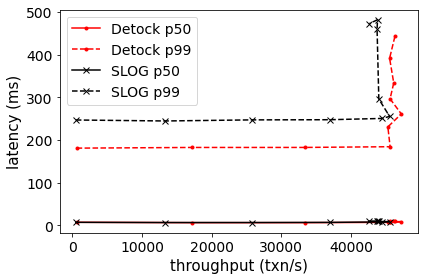

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
config_names = ["ddr_ts.conf", "baseline.conf"]
config_to_label = {
    'baseline.conf': 'SLOG',
    'ddr_only.conf': 'Detock (without Opportunistic Ordering)',
    'ddr_ts.conf': 'Detock'
}

ax.set_prop_cycle((cycler(marker=['.', 'x']) + cycler(color='rk')) * cycler(linestyle=['-', '--']))

for config in config_names:
    label = config_to_label[config]
    throughput_latency_df[throughput_latency_df.config_name == config].plot(x="throughput", y="latency_50", label=f"{label} p50", ax=ax)
    throughput_latency_df[throughput_latency_df.config_name == config].plot(x="throughput", y="latency_99", label=f"{label} p99", ax=ax)

ax.set_ylabel("latency (ms)")
ax.set_xlabel("throughput (txn/s)")
fig.tight_layout()
fig.savefig('output/tpcc-throughput-latency.pdf')